calculate spearman correlation coefficient matrix

In [ ]:
import pandas as pd
from scipy.stats import spearmanr

# Beispiel-Daten erstellen
data = {
    'wind_speed': [1, 2, 3, 4, 5],
    'temperature': [5, 6, 7, 8, 7],
    'pressure': [10, 9, 2, 4, 3],
    'production': []
}
df = pd.DataFrame(data)

# Spearman-Korrelationsmatrix berechnen
spearman_corr_matrix = df.corr(method='spearman')

print("Spearman-Korrelationsmatrix:")
print(spearman_corr_matrix)


load historical weather data (pressure, temperautre, wind speed)

In [ ]:
import numpy as np
import xarray as xr
import netCDF4 as nc
from netCDF4 import num2date

# File paths
pressure_file = "data/weather_history/COSMO_REA6/PS.2D.201501.grb"
temperature_file = "data/weather_history/COSMO_REA6/T_2M.2D.201501.grb"
wind_speed_file = "data/weather_history/COSMO_REA6/WS_100m.2D.201501.nc4"

# Load datasets
pressure = xr.open_dataset(pressure_file, engine="cfgrib")
temperature = xr.open_dataset(temperature_file, engine="cfgrib")
wind_speed = nc.Dataset(wind_speed_file)

number_hours = 1

pressure_lons = pressure.longitude.values
pressure_lats = pressure.latitude.values
pressure_times = pressure.time.values[:number_hours]
pressure_values = pressure['sp'].values[:number_hours,:,:]

temperature_lons = temperature.longitude.values
temperature_lats = temperature.latitude.values
temperature_times = temperature.time.values[:number_hours]
temperature_values = temperature['t2m'].values[:number_hours,:,:]

wind_speed_lons = wind_speed['RLON'][:]
wind_speed_lons = np.where(wind_speed_lons > 180, wind_speed_lons - 360, wind_speed_lons)
wind_speed_lats = wind_speed['RLAT'][:]
wind_speed_time_unit = wind_speed['time'].units
wind_speed_times = num2date(wind_speed['time'][:number_hours], wind_speed_time_unit)
wind_speed_times = np.array([np.datetime64(t.strftime('%Y-%m-%dT%H:%M:%S')) for t in wind_speed_times])
wind_speed_values = wind_speed['wind_speed'][:number_hours,:,:].filled(np.nan) # convert masked array to regular array by converting masked values to nan values

def is_equal(array1, array2):
    abs_difference = np.abs(array1-array2)
    average_difference = np.mean(abs_difference)
    if np.array_equal(array1, array2):
        print('arrays equal')
    elif average_difference < 0.1:
        print('difference negligible')
    else:
        print('arrays not equal')
        print("average difference:", np.mean(abs_difference))
        print("median difference:", np.median(abs_difference))
        print("minimal difference:", np.max(abs_difference))
        print("maximal difference:", np.min(abs_difference))

is_equal(pressure_lons, temperature_lons)
is_equal(pressure_lons, wind_speed_lons)
is_equal(pressure_lats, temperature_lats)
is_equal(pressure_lats, wind_speed_lats)
is_equal(pressure_times, temperature_times)
is_equal(pressure_times, wind_speed_times)

# # scatter plot
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 6))
# plt.scatter(pressure_lon, pressure_lat, c='blue', marker='o')
# plt.title('Scatter-Diagramm der Längen- und Breitengradwerte')
# plt.xlabel('Längengrad')
# plt.ylabel('Breitengrad')
# plt.grid(True)
# plt.show()

np.save("data/weather_history/COSMO_REA6/lons.npy", pressure_lons)
np.save("data/weather_history/COSMO_REA6/lats.npy", pressure_lats)
np.save("data/weather_history/COSMO_REA6/times.npy", pressure_times)
np.save("data/weather_history/COSMO_REA6/pressure_values.npy", pressure_values)
np.save("data/weather_history/COSMO_REA6/temperature_values.npy", temperature_values)
np.save("data/weather_history/COSMO_REA6/wind_speed_values.npy", wind_speed_values)

load historical weather data (wind speed)

In [4]:
import numpy as np
import netCDF4 as nc
from netCDF4 import num2date

wind_speed_file = "data/weather_history/COSMO_REA6/WS_100m.2D.201501.nc4"

wind_speed = nc.Dataset(wind_speed_file)

number_hours = 48

lons = wind_speed['RLON'][:].filled(np.nan)
lons = np.where(lons > 180, lons - 360, lons)
lats = wind_speed['RLAT'][:].filled(np.nan)
time_unit = wind_speed['time'].units
times = num2date(wind_speed['time'][:number_hours], time_unit)
times = np.array([np.datetime64(t.strftime('%Y-%m-%dT%H:%M:%S')) for t in times])
wind_speeds = wind_speed['wind_speed'][:number_hours,:,:].filled(np.nan) # convert masked array to regular array by converting masked values to nan values

np.save("data/weather_history/COSMO_REA6/lons.npy", lons)
np.save("data/weather_history/COSMO_REA6/lats.npy", lats)
np.save("data/weather_history/COSMO_REA6/times.npy", times)
np.save("data/weather_history/COSMO_REA6/wind_speeds.npy", wind_speeds)

save WPPs in parquet file

In [ ]:
import pandas as pd

lat_min, lat_max = 35, 72
lon_min, lon_max = -25, 45

# Lade die Excel-Datei nur einmal, filtere die relevanten Daten und speichere sie als Parquet-Datei
WPP_file = "data/WPPs/Global-Wind-Power-Tracker-June-2024.xlsx"
df = pd.read_excel(WPP_file, sheet_name='Data')

# Filtere die Daten für Europa
df_filtered = df[(df['Latitude'] >= lat_min) & (df['Latitude'] <= lat_max) & (df['Longitude'] >= lon_min) & (df['Longitude'] <= lon_max)]

# Wähle nur die benötigten Spalten aus
df_filtered = df_filtered[['Latitude', 'Longitude', 'Capacity (MW)', 'Project Name', 'Status', 'Operator', 'Owner', 'Start year']]

# Speichere die gefilterten Daten im Parquet-Format (deutlich schneller zu lesen und schreiben, als Excel-Dateien, und auch platzsparender)
df_filtered.to_parquet("data/WPPs/Global-Wind-Power-Tracker-Europe.parquet")

In [ ]:
import pandas as pd

# Lade die Excel-Datei nur einmal, filtere die relevanten Daten und speichere sie als Parquet-Datei
WPP_file = "data/WPPs/Windfarms_Europe_20241123.xlsx"
df = pd.read_excel(WPP_file, sheet_name='Windfarms', na_values=["#ND"])
df = df.drop(0) # remove first row (after headlines)

# Wähle nur die benötigten Spalten aus
df = df[['Name', '2nd name', 'Latitude', 'Longitude', 'Manufacturer', 'Turbine', 'Hub height', 'Number of turbines', 'Total power', 'Developer', 'Operator', 'Owner', 'Commissioning date', 'Status']]

# Entferne Zeilen, bei denen Name, 2nd name, Latitude oder Longitude NaN ist
df = df.dropna(subset=['Name', '2nd name', 'Latitude', 'Longitude'])

# Behalte nur Zeilen, bei denen Status == "Production"
df = df.loc[df['Status'] == 'Production']

# Konvertiere Spalten explizit in ihre entsprechenden Datentypen
df['Name'] = df['Name'].astype(str)
df['2nd name'] = df['2nd name'].astype(str)
df['Latitude'] = df['Latitude'].astype(float)
df['Longitude'] = df['Longitude'].astype(float)
df['Manufacturer'] = df['Manufacturer'].astype(str)
df['Turbine'] = df['Turbine'].astype(str)
df['Hub height'] = df['Hub height'].astype(float)
df['Number of turbines'] = df['Number of turbines'].fillna(0).astype(int)
df['Total power'] = df['Total power'].astype(float)
df['Developer'] = df['Developer'].astype(str)
df['Operator'] = df['Operator'].astype(str)
df['Owner'] = df['Owner'].astype(str)
df['Commissioning date'] = df['Commissioning date'].astype(str)
df['Status'] = df['Status'].astype(str)

# Speichere die gefilterten Daten im Parquet-Format (deutlich schneller zu lesen und schreiben, als Excel-Dateien, und auch platzsparender)
df.to_parquet("data/WPPs/The_Wind_Power.parquet")


save production history example as parquet file

In [ ]:
import pandas as pd

# Lade die Excel-Datei nur einmal, filtere die relevanten Daten und speichere sie als Parquet-Datei
example_file = "data/production_history/Example/example_time_series.xlsx" 
df = pd.read_excel(example_file)

# Speichere die gefilterten Daten im Parquet-Format (deutlich schneller zu lesen und schreiben, als Excel-Dateien, und auch platzsparender)
df.to_parquet("data/production_history/Example/example_time_series.parquet")

wind speeds (COSMO-REA6)

In [ ]:
import netCDF4 as nc

fn = r"C:\Users\alexa\Documents\Webapp\data\weather history\WS_100m.2D.199501.nc4" # January 1995
ds = nc.Dataset(fn)

print(ds)

time = ds.variables['time'][:]
lon = ds.variables['RLON'][:]
lat = ds.variables['RLAT'][:]
wind_speed = ds.variables['wind_speed'][:]

for i in range(len(lon)):
    for j in range(len(lon[0])):
        lon[i,j] = lon[i,j] - 360 if lon[i,j] > 180 else lon[i,j]
    

three different visualisations

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


# Erstelle eine Karte mit cartopy
plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Trage die Windgeschwindigkeit auf der Karte ein
plt.contourf(lon, lat, wind_speed[0,:,:], transform=ccrs.PlateCarree(), cmap='viridis')

# Füge Küstenlinien hinzu
ax.coastlines()

# Zeige die Karte
plt.colorbar(label="Windgeschwindigkeit (m/s)")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Erstelle eine Karte mit curvilinearen Daten
plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Zeichne die Windgeschwindigkeit auf dem curvilinearen Gitter
plt.pcolormesh(lon, lat, wind_speed[0,:,:], transform=ccrs.PlateCarree(), cmap='viridis')

# Füge Küstenlinien hinzu
ax.coastlines()

# Zeige die Karte
plt.colorbar(label="Windgeschwindigkeit (m/s)")
plt.show()


In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Verwende eine Lambert-Projektion
ax = plt.axes(projection=ccrs.LambertConformal())

# Zeichne die Windgeschwindigkeit auf dem curvilinearen Gitter
plt.contourf(lon, lat, wind_speed[0,:,:], transform=ccrs.PlateCarree(), cmap='coolwarm')

# Küstenlinien und Raster hinzufügen
ax.coastlines()
ax.gridlines()

plt.colorbar(label="Windgeschwindigkeit (m/s)")
plt.show()


power curve

In [ ]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Definiere die Power Curve (Windgeschwindigkeit und Leistung)
wind_speeds = np.arange(0, 25.5, 0.5)  # Windgeschwindigkeiten
power_output = [0]*7 + [35, 80, 155, 238, 350, 474, 630, 802, 1018, 1234, 1504, 1773, 2076, 2379, 2664, 2948, 3141, 3334, 3425, 3515, 3546, 3577, 3586, 3594, 3598, 3599] + [3600]*18  # Leistung
max_cap = 3600
power_output_norm = [x / max_cap for x in power_output]
wind_speed_max = 25

# Erstelle die Interpolationsfunktion
interpolation_function = interp1d(wind_speeds, power_output_norm, kind='cubic', fill_value="extrapolate")

# Beispiel für Interpolation: Bestimme Werte für feinere Windgeschwindigkeiten
fine_wind_speeds = np.linspace(0, 25, 100)  # Feinere Windgeschwindigkeiten
interpolated_power_output = interpolation_function(fine_wind_speeds)

# Plot der diskreten und interpolierten Power Curve
plt.figure(figsize=(10, 6))
plt.plot(wind_speeds, power_output_norm, 'o', label='Diskrete Werte')  # Diskrete Punkte
plt.plot(fine_wind_speeds, interpolated_power_output, '-', label='Interpolierte Werte')  # Interpolierte Werte
plt.xlabel('Windgeschwindigkeit (m/s)')
plt.ylabel('Leistung (kW)')
plt.title('Interpolierte Power Curve')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd

# Datei laden (relativer Pfad)
file_path = "./Global-Wind-Power-Tracker-June-2024.xlsx"
df = pd.read_excel(file_path, sheet_name='Data')

# Bereich für Europa definieren
lat_min, lat_max = 35, 72
lon_min, lon_max = -25, 45

# Filtere die Daten für den geografischen Bereich in Europa
df_filtered = df[(df['Latitude'] >= lat_min) & (df['Latitude'] <= lat_max) & 
                 (df['Longitude'] >= lon_min) & (df['Longitude'] <= lon_max)]

WPPs capacity distribution

In [ ]:
import matplotlib.pyplot as plt

# Verteilung der Kapazität berechnen
capacity_distribution = df_filtered['Capacity (MW)'].value_counts()

# Diagramm erstellen, nur bis zum Maximalwert
plt.figure(figsize=(10, 6))
plt.hist(df_filtered['Capacity (MW)'].dropna(), bins=1000, range=(0, 2000), edgecolor='black')
plt.title('Verteilung der Windkraftanlagenkapazitäten in Europa')
plt.xlabel('Kapazität (MW)')
plt.ylabel('Anzahl')
plt.grid(True)
plt.show()

visualisation of WPPs

In [ ]:
from ipyleaflet import Map, Marker, MarkerCluster
from ipywidgets import Layout

# Erstelle die Karte
m = Map(center=[(lat_min + lat_max) / 2, (lon_min + lon_max) / 2],
        zoom=5,
        layout=Layout(width='100%', height='500px')
       )

# Erstelle Marker-Objekte für jede Windkraftanlage
markers = [Marker(location=(row['Latitude'], row['Longitude'])) for _, row in df_filtered.iterrows()]

# Erstelle einen Marker Cluster
marker_cluster = MarkerCluster(markers=markers, disable_clustering_at_zoom=18)

# Füge den Marker Cluster zur Karte hinzu
m.add_layer(marker_cluster)

# Zeige die Karte an
m

data generation with power curve

In [ ]:
import numpy as np

# Masked array in ein reguläres Array umwandeln
wind_speed_array = np.ma.filled(wind_speed[0,:,:], np.nan)

# Verteilung der Kapazitäten aus 'Capacity (MW)'
capacity_distribution = df_filtered['Capacity (MW)'].dropna().values

# Häufigkeiten der Kapazitäten berechnen
unique_capacities, counts = np.unique(capacity_distribution, return_counts=True)

# Wahrscheinlichkeiten für jede Kapazität (relative Häufigkeit)
probabilities = counts / counts.sum()

# Initialisiere die np.array Strukturen für die Daten
data = np.zeros((3, wind_speed_array.size))  # 3 Reihen für wind_speed, capacity, production

# Skaliere die Produktion basierend auf der Verteilung mit gewichteter Auswahl
for i in range(wind_speed_array.shape[0]):
    for j in range(wind_speed_array.shape[1]):
        wind_speed_select = wind_speed_array[i, j] # Verwende alle Windgeschwindigkeiten von Januar 1995
        capacity = np.random.choice(unique_capacities, p=probabilities) # Wähle eine Kapazität basierend auf ihrer Wahrscheinlichkeit
        production = interpolation_function(wind_speed_select) * capacity
        production = production if wind_speed_select < wind_speed_max else 0
                
        # Fülle die Werte in das np.array
        data[0, i*wind_speed_array.shape[0]+j] = wind_speed_select  # Windgeschwindigkeit
        data[1, i*wind_speed_array.shape[0]+j] = capacity  # Kapazität
        data[2, i*wind_speed_array.shape[0]+j] = production # Produktion


ANN with PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Verwende dein generiertes numpy Array mit Wind Speed, Capacity und Scaled Production
# data[0, :] -> Windgeschwindigkeit
# data[1, :] -> Kapazität
# data[2, :] -> Skalierte Produktion

X = data[:2, :].T  # Features: Erste zwei Reihen, transponiert zu (Anzahl der Datenpunkte, 2)
y = data[2, :]  # Target: Dritte Reihe (scaled production)

# Normalisierung der Features
scaler = StandardScaler()
X = scaler.fit_transform(X)  # Normiere Windgeschwindigkeit und Kapazität auf Standardnormalverteilung

# Train/Test Split (80% Training, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Konvertiere die Numpy Arrays in PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Output Tensor (2D, mit shape [N, 1])
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Erstellen des ANN-Modells
class ANN_Model(nn.Module):
    def __init__(self):
        super(ANN_Model, self).__init__()
        # Input Layer: 2 Features (Wind Speed und Capacity)
        # Hidden Layer 1: 64 Neuronen
        # Hidden Layer 2: 32 Neuronen
        # Output Layer: 1 (Scaled Production)
        self.fc1 = nn.Linear(2, 64)  # Eingabe: 2 Features
        self.fc2 = nn.Linear(64, 32)  # Erste versteckte Schicht
        self.fc3 = nn.Linear(32, 1)  # Ausgabe: 1 Wert (Scaled Production)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialisiere das Modell, den Optimizer und die Loss-Funktion
model = ANN_Model()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # Mean Squared Error für Regression

# Training des Modells
epochs = 500
losses = []

for epoch in range(epochs):
    model.train()
    
    # Vorwärtsdurchlauf
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Rückwärtsdurchlauf und Optimierung
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Speichern des Verlusts
    losses.append(loss.item())
    
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Plotte den Trainingsverlust
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

# Teste das Modell
model.eval()
with torch.no_grad(): # don't calculate gradient: model remains tel quel during testing
    predictions = model(X_test_tensor)
    test_loss = criterion(predictions, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

# Forecast auf Basis hypothetischer Werte (z.B. hypothetische Wind Speed und Capacity)
hypothetical_data = np.array([[12, 1500], [8, 3000], [20, 500]])  # Beispielwerte: [Wind Speed, Capacity]
hypothetical_tensor = torch.tensor(hypothetical_data, dtype=torch.float32)

# Vorhersagen machen
with torch.no_grad(): # don't calculate gradient: model remains tel quel during forecasting
    forecasted_production = model(hypothetical_tensor)
    print(f'Hypothetische Vorhersagen (Wind Speed, Capacity -> Scaled Production): {forecasted_production}')


ANN with tensorflow

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Beispiel-Daten (Windgeschwindigkeit, Kapazität, Produktion)
# Nehmen wir an, 'data' ist ein Vektor mit drei Listen:
wind_speed = data[0]  # Erste Zeile: Windgeschwindigkeiten
capacity_mw = data[1]  # Zweite Zeile: Kapazität (MW)
scaled_production = data[2]  # Dritte Zeile: Produktion (Scaled Production)

# Eingabedaten als Feature-Array
X = np.column_stack((wind_speed, capacity_mw))

# Zielwert (Scaled Production)
y = scaled_production

# Daten aufteilen in Trainings- und Testdatensatz (80% Training, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Daten normalisieren (wichtig für ein stabiles Training)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Erstelle das Modell (ANN)
model = Sequential()

# Eingabeschicht und erste verborgene Schicht (mit 64 Neuronen und ReLU-Aktivierungsfunktion)
model.add(Dense(64, input_dim=2, activation='relu'))

# Zweite verborgene Schicht
model.add(Dense(64, activation='relu'))

# Ausgabeschicht (1 Neuron für die Vorhersage der Produktion)
model.add(Dense(1, activation='linear'))

# Kompiliere das Modell mit Adam Optimizer und Mean Squared Error als Verlustfunktion
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Trainiere das Modell auf den Trainingsdaten
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_test_scaled, y_test))

# Evaluierung des Modells auf den Testdaten
loss = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'Test Loss (Mean Squared Error): {loss}')

# Vorhersage auf neuen hypothetischen Daten (z.B. Kapazität=4.5 MW, Windgeschwindigkeit=15 m/s)
hypothetical_data = np.array([[15, 4.5]])
hypothetical_data_scaled = scaler.transform(hypothetical_data)
predicted_production = model.predict(hypothetical_data_scaled)

print(f'Hypothetische Vorhersage der Produktion: {predicted_production[0][0]}')

# Vorhersage auf den Testdaten (zum Vergleich)
predictions = model.predict(X_test_scaled)


Training Data

In [ ]:
production = r"C:\Users\alexa\Documents\Webapp\data\production_history\processed\production_summary_"


Preprocessing of historical production data: discard data from unwanted power plants, retain monthly files

In [ ]:
import pandas as pd
import os

# Basisverzeichnisse
input_dir = r"C:\Users\alexa\Documents\Webapp\data\production_history\raw"
output_dir = r"C:\Users\alexa\Documents\Webapp\data\production_history\processed"

# Liste der Monate von 2015_06 bis 2024_10 generieren
months = pd.date_range(start="2015-05", end="2024-10", freq="MS").strftime("%Y_%m").tolist()

# For-Schleife für jede Datei
for month in months:
    # Dateipfad erstellen
    input_file = os.path.join(input_dir, f"{month}_ActualGenerationOutputPerGenerationUnit_16.1.A_r2.1.csv")
    output_file = os.path.join(output_dir, f"production_summary_{month}.xlsx")

    # Überprüfen, ob die Datei existiert
    if not os.path.exists(input_file):
        print(f"Datei nicht gefunden: {input_file}")
        continue  # Überspringt diese Iteration, wenn die Datei nicht existiert

    # Datei einlesen
    print(f"Bearbeite Datei: {input_file}")
    data = pd.read_csv(input_file, sep='\t')

    # Filtere nach GenerationUnitType == 'Wind Onshore' oder 'Wind Offshore'
    filtered_data = data[(data['GenerationUnitType'] == 'Wind Onshore ') | (data['GenerationUnitType'] == 'Wind Offshore ')]

    # Wichtige Spalten identifizieren
    unique_windfarms = filtered_data[['GenerationUnitName', 'GenerationUnitCode', 'GenerationUnitType', 'AreaDisplayName', 'MapCode', 'AreaTypeCode', 'GenerationUnitInstalledCapacity(MW)']].drop_duplicates()

    # Listen für die Produktion zu jeder Stunde hinzufügen
    production_data = []
    for _, row in unique_windfarms.iterrows():
        windfarm_data = filtered_data[filtered_data['GenerationUnitName'] == row['GenerationUnitName']]
        production_values = windfarm_data['ActualGenerationOutput(MW)'].tolist()
        row_data = {
            'GenerationUnitName': row['GenerationUnitName'],
            'GenerationUnitCode': row['GenerationUnitCode'],
            'GenerationUnitType': row['GenerationUnitType'],
            'GenerationUnitInstalledCapacity(MW)': row['GenerationUnitInstalledCapacity(MW)'],
            'AreaDisplayName': row['AreaDisplayName'],
            'MapCode': row['MapCode'],
            'AreaTypeCode': row['AreaTypeCode'],
            'Production (MW)': [production_values]  # Hier die Produktion als Liste speichern
        }
        production_data.append(row_data)

    # DataFrame erstellen und in Excel speichern
    output_df = pd.DataFrame(production_data)
    output_df.to_excel(output_file, index=False)

    print(f"Excel-Datei wurde erfolgreich erstellt: {output_file}")


['2024_10']
Bearbeite Datei: C:\Users\alexa\Documents\Webapp\data\production_history\raw\2024_10_ActualGenerationOutputPerGenerationUnit_16.1.A_r2.1.csv
Excel-Datei wurde erfolgreich erstellt: C:\Users\alexa\Documents\Webapp\data\production_history\processed\production_summary_2024_10.xlsx


Preprocessing of historical production data: merge all monthly files

In [51]:
import pandas as pd
import os

# Verzeichnisse
input_dir = r"C:\Users\alexa\Documents\Webapp\data\production_history\processed"
output_file = r"C:\Users\alexa\Documents\Webapp\data\production_history\production_summary_all.xlsx"

# Liste der Monate von 2015_01 bis 2024_10
months = pd.date_range(start="2015-01", end="2024-10", freq="MS").strftime("%Y_%m").tolist()

columns_old = ['GenerationUnitName', 'GenerationUnitCode', 'GenerationUnitType', 'GenerationUnitInstalledCapacity(MW)', 'AreaDisplayName', 'MapCode', 'AreaTypeCode']
# Leeres DataFrame für das Endergebnis
columns = columns_old + months
final_df = pd.DataFrame(columns=columns)

# Einlesen der einzelnen Dateien
for month in months:
    input_file = os.path.join(input_dir, f"production_summary_{month}.xlsx")

    # Überprüfen, ob die Datei existiert
    if not os.path.exists(input_file):
        print(f"Datei nicht gefunden: {input_file}")
        continue

    # Datei einlesen
    print(f"Verarbeite Datei: {input_file}")
    df = pd.read_excel(input_file)

    # Sicherstellen, dass die Spalte 'Production (MW)' existiert
    if 'Production (MW)' not in df.columns:
        print(f"Spalte 'Production (MW)' fehlt in {input_file}")
        continue

    df.rename(columns={'Production (MW)': month}, inplace=True)

    # Zusammenführen der Daten
    if final_df.empty:
        final_df = df
    else:
        # Zusammenführen: Gleiche Windkraftanlagen zusammenführen, neue hinzufügen
        final_df = pd.merge(final_df, df, how='outer', on=columns_old)

# Excel-Tabelle speichern
final_df.to_excel(output_file, index=False)
print(f"Zusammengeführte Excel-Tabelle wurde erfolgreich gespeichert unter: {output_file}")


Verarbeite Datei: C:\Users\alexa\Documents\Webapp\data\production_history\processed\production_summary_2015_01.xlsx
Verarbeite Datei: C:\Users\alexa\Documents\Webapp\data\production_history\processed\production_summary_2015_02.xlsx
Verarbeite Datei: C:\Users\alexa\Documents\Webapp\data\production_history\processed\production_summary_2015_03.xlsx
Verarbeite Datei: C:\Users\alexa\Documents\Webapp\data\production_history\processed\production_summary_2015_04.xlsx
Verarbeite Datei: C:\Users\alexa\Documents\Webapp\data\production_history\processed\production_summary_2015_05.xlsx
Verarbeite Datei: C:\Users\alexa\Documents\Webapp\data\production_history\processed\production_summary_2015_06.xlsx
Verarbeite Datei: C:\Users\alexa\Documents\Webapp\data\production_history\processed\production_summary_2015_07.xlsx
Verarbeite Datei: C:\Users\alexa\Documents\Webapp\data\production_history\processed\production_summary_2015_08.xlsx
Verarbeite Datei: C:\Users\alexa\Documents\Webapp\data\production_histor

Visualise filling rate of production data file (1)

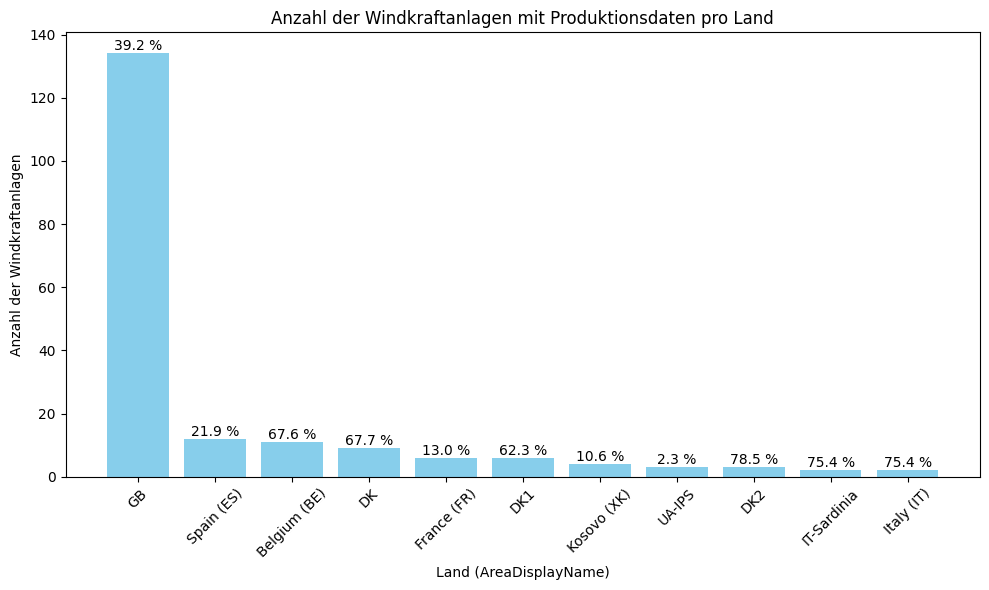

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Datei laden
file_path = r"C:\Users\alexa\Documents\Webapp\data\production_history\processed\production_summary_all.xlsx"
df = pd.read_excel(file_path)

# Anzahl der Windkraftanlagen pro AreaDisplayName
counts = df['AreaDisplayName'].value_counts()

# Berechnung der prozentualen Ausfüllquote pro AreaDisplayName
percentages = {}
for area in counts.index:
    subset = df[df['AreaDisplayName'] == area]
    total_cells = len(subset) * (len(subset.columns) - 6)  # Exkludiere nicht-produktive Spalten
    filled_cells = subset.iloc[:, 6:].notna().sum().sum()  # Nur Produktionsdaten berücksichtigen
    percentages[area] = (filled_cells / total_cells) * 100

# Balkendiagramm erstellen
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(counts.index, counts.values, color='skyblue')
ax.set_title('Anzahl der Windkraftanlagen mit Produktionsdaten pro Land')
ax.set_xlabel('Land (AreaDisplayName)')
ax.set_ylabel('Anzahl der Windkraftanlagen')
ax.tick_params(axis='x', rotation=45)

# Prozentsätze als Text hinzufügen
for bar, area in zip(bars, counts.index):
    height = bar.get_height()
    percentage = percentages[area]
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.1f} %', ha='center', va='bottom')

plt.tight_layout()
plt.show()


Visualise filling rate of production data file (2)

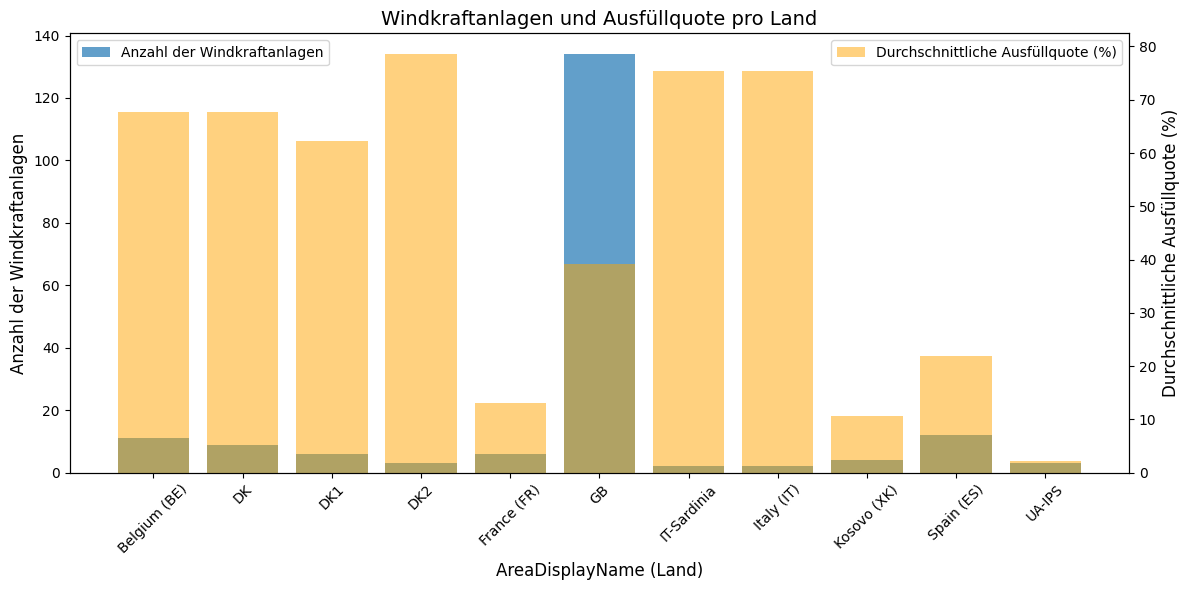

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Datei laden
file_path = r"C:\Users\alexa\Documents\Webapp\data\production_history\processed\production_summary_all.xlsx"
df = pd.read_excel(file_path)

# Liste der Monatskolumnen
month_columns = [col for col in df.columns if col.startswith("20")]

# Anzahl der Windkraftanlagen pro AreaDisplayName (Land)
windfarm_count = df.groupby("AreaDisplayName").size()

# Durchschnittliche Ausfüllquote pro Land
fill_rates = df[month_columns].notna().mean(axis=1)  # Berechne pro Windkraftanlage
average_fill_rate_per_country = df.groupby("AreaDisplayName")[month_columns].apply(
    lambda x: x.notna().mean(axis=1).mean()
)

# Plot erstellen
fig, ax1 = plt.subplots(figsize=(12, 6))

# Linke y-Achse: Anzahl der Windkraftanlagen
ax1.bar(
    windfarm_count.index,
    windfarm_count.values,
    label="Anzahl der Windkraftanlagen",
    alpha=0.7
)
ax1.set_ylabel("Anzahl der Windkraftanlagen", fontsize=12)
ax1.set_xlabel("AreaDisplayName (Land)", fontsize=12)
ax1.tick_params(axis="x", rotation=45)
ax1.legend(loc="upper left")

# Rechte y-Achse: Durchschnittliche Ausfüllquote
ax2 = ax1.twinx()
ax2.bar(
    average_fill_rate_per_country.index,
    average_fill_rate_per_country.values * 100,  # Prozentualer Wert
    label="Durchschnittliche Ausfüllquote (%)",
    alpha=0.5,
    color="orange"
)
ax2.set_ylabel("Durchschnittliche Ausfüllquote (%)", fontsize=12)
ax2.legend(loc="upper right")

# Titel und Layout
plt.title("Windkraftanlagen und Ausfüllquote pro Land", fontsize=14)
plt.tight_layout()

# Plot anzeigen
plt.show()


Download table to find common name for UK power plants from website

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL der Webseite
url = "https://osuked.github.io/Power-Station-Dictionary/dictionary.html"

# Abrufen der Webseite
response = requests.get(url)
if response.status_code != 200:
    print("Fehler beim Abrufen der Webseite.")
    exit()

# Parsing der Webseite mit BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')

# Finden aller Tabellen auf der Seite
tables = soup.find_all('table')
if len(tables) < 3:
    print("Weniger als 3 Tabellen auf der Seite gefunden.")
    exit()

# Die dritte Tabelle auswählen (Index 2, da Python nullbasiert zählt)
table = tables[2]

# Spaltennamen extrahieren
headers = [header.text.strip() for header in table.find_all('th')]

# Zeilen extrahieren
rows = []
for row in table.find_all('tr')[1:]:  # Überspringt die Kopfzeile
    cells = [cell.text.strip() for cell in row.find_all('td')]
    rows.append(cells)

# DataFrame erstellen
df = pd.DataFrame(rows, columns=headers)

# Datei speichern
output_path = "data/WPPs/Power_Station_Dictionary.xlsx"
df.to_excel(output_path, index=False)
print(f"Die dritte Tabelle wurde erfolgreich als '{output_path}' gespeichert.")


Die dritte Tabelle wurde erfolgreich als 'data/WPPs/Power_Station_Dictionary_Third_Table.xlsx' gespeichert.


Add common names from downloaded to assignment file

In [58]:
import pandas as pd

# Load the two provided files
file_1_path = r"C:\Users\alexa\Documents\Webapp\data\WPPs\Power_Station_Dictionary.xlsx"
file_2_path = r"C:\Users\alexa\Documents\Webapp\data\Assignment.xlsx"

# Read the first file (Power Station Dictionary)
df1 = pd.read_excel(file_1_path)

# Read the second file (Assignment data, Sheet2)
df2 = pd.read_excel(file_2_path, sheet_name="Sheet2")

# Iterate over rows in df2 to match and update the "Names_UK_Plants" column
for index, row in df2.iterrows():
    generation_unit_name = row['GenerationUnitName']
    
    # Check if this name appears in the "National Grid BMU ID" of the first file
    matching_rows = df1[df1['National Grid BMU ID'].str.contains(generation_unit_name, na=False, case=False)]
    
    if not matching_rows.empty:
        # Get the "Common Name" value(s) and update the "Names_UK_Plants" column in df2
        common_names = matching_rows['Common Name'].tolist()
        df2.at[index, 'Names_UK_Plants'] = ', '.join(common_names)

# Save the updated DataFrame to a new Excel file
output_path = r"C:\Users\alexa\Documents\Webapp\data\Assignment_Updated.xlsx"
df2.to_excel(output_path, index=False)

output_path


'C:\\Users\\alexa\\Documents\\Webapp\\data\\Assignment_Updated.xlsx'